In [80]:
%load_ext blackcellmagic

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.datasets import mnist
from keras.layers import (
    Conv2D, Dense, Flatten, Input, MaxPooling2D, Reshape, UpSampling2D)
from keras.models import Model, Sequential, load_model
from keras.utils import to_categorical

from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [2]:
# this is the size of our encoded representations
ENCODING_DIM = 10

# decision boundary for classifier
THRESHOLD = 0.7

# working directory
CUR_DIR = os.path.curdir

# setting random seed for reproducable results
np.random.seed(42)

In [84]:
def train_test_split(X, y, train_split=0.7, test_split=0.85):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]

    # define boundaries for train,validation and test set at .7 and .85 % of the MNIST data set
    x_len = len(X)
    boundaries = [int(x_len * 0.7), int(x_len * 0.85)]

    [X_train, X_test, X_validate] = np.split(X, boundaries)

    [y_train, y_test, y_validate] = np.split(y, boundaries)
    return (X_train, X_test, X_validate), (y_train, y_test, y_validate)

In [3]:
def get_data(train_split=.7, test_split=.85):
    """retrieves data MNIST data set and rebalances dataset, such that train=.7, test=.15 and validation=.15"""
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    X_train = X_train.reshape((len(X_train), 28, 28, 1))
    test_len = len(X_test)

    X_test = X_test.reshape((test_len, 28, 28, 1))

    # divide X values bei 255.0 since MNIST data set changed such that pixel values are in [0,255]
    X = np.concatenate((X_train, X_test)) / 255.0
    y = np.concatenate((y_train, y_test))
  
    (X_train, X_test, X_validate), (y_train, y_test, y_validate) = train_test_split(X,y) # defaul: .7, .85
    # one-hot encode target columns
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    y_validate = to_categorical(y_validate)

    return (X_train, X_test, X_validate), (y_train, y_test, y_validate)

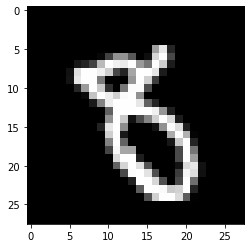

In [4]:
(X_train, X_test, X_validate), (y_train, y_test, y_validate) = get_data()
plt.imshow(X_train[2].reshape((28,28)),cmap="gray")

In [30]:
def get_specific_data_set(X, y, digit):
    # parameters are training AND test data for X respectively y 
    # is assumed to be in one-hot-encoding
    y = np.argmax(y, axis=1)
    indices = np.where(y == digit)

    # filtering by the passed digit. needs to be an int
    X_digit = X[indices]    
    y_digit = y[indices]
     
    y_digit = to_categorical(y_digit) # array of length 2 of form [0., 1.]
    
    # splitting in training and test sets is not necessary, 
    # because anomaly detection without knowledge of the labels is aimed for.
    
    return X_digit, y_digit

In [83]:
X = np.concatenate((X_train, X_test, X_validate))
y = np.concatenate((y_train, y_test, y_validate))

# digit = 0
# X_zero, y_zero = get_specific_data_set(X, y, digit)
# digit = 8
# X_eight, y_eight = get_specific_data_set(X, y, digit)
# digit = 1
# X_one, y_one =  get_specific_data_set(X, y, digit)
# digit = 7
# X_seven, y_seven = get_specific_data_set(X, y, digit)
digit_data = [get_specific_data_set(X, y, i) for i in range(10)]
len(digit_data)

10

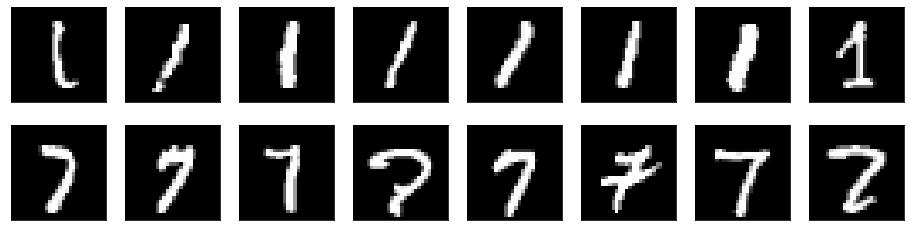

In [74]:
plt.figure(figsize=(16, 4))
for i in range(len(X_one))[:8]:
    ax = plt.subplot(2, 8, i+1)
    plt.imshow(digit_data[1][0][i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
for i in range(len(X_one))[:8]:
    ax = plt.subplot(2, 8, 8+i+1)
    plt.imshow(digit_data[7][0][i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [66]:
def build_classifier(input_dim):
    """Builds classifier for classification of MNIST encoded representation."""
    classifier = Sequential()
    classifier.add(Dense(32, activation="relu", input_dim=input_dim,
                         kernel_initializer="random_normal"))
    classifier.add(Dense(ENCODING_DIM, activation="softmax",
                         kernel_initializer="random_normal"))

    classifier.compile(optimizer='adam', loss='mean_squared_error',
                       metrics=['accuracy'])
    return classifier

In [99]:
def build_conv_aue():
    INPUT_SHAPE = (28, 28, 1)
    DEFAULT_KERNEL = (3, 3)
    DEFAULT_POOL_SIZE = (2, 2)
    # this is our input placeholder
    input_img = Input(shape=INPUT_SHAPE)
    # layer between input and middle layer
    encode = Conv2D(16, DEFAULT_KERNEL, activation="relu",
                    padding="same")(input_img)
    encode = MaxPooling2D(DEFAULT_POOL_SIZE, padding="same")(encode)
    encode = Conv2D(8, DEFAULT_KERNEL, activation="relu",
                    padding="same")(encode)
    encode = MaxPooling2D(DEFAULT_POOL_SIZE, padding="same")(encode)
    encode = Conv2D(8, DEFAULT_KERNEL, activation="relu",
                    padding="same")(encode)
    encode = MaxPooling2D(DEFAULT_POOL_SIZE, padding="same")(encode)
    encode = Conv2D(6, DEFAULT_KERNEL, activation="relu",
                    padding="same")(encode)

    # "encoded" is the encoded representation of the input, middle layer of the aue
    encoded = MaxPooling2D(
        DEFAULT_POOL_SIZE, padding="same", name="encoder")(encode)

    # layer between middle and output layer
    decode = Conv2D(6, DEFAULT_KERNEL, activation="relu", padding="same"
                    )(encoded)
    decode = UpSampling2D(DEFAULT_POOL_SIZE)(decode)
    decode = Conv2D(8, DEFAULT_KERNEL, activation="relu", padding="same"
                    )(decode)
    decode = UpSampling2D(DEFAULT_POOL_SIZE)(decode)
    decode = Conv2D(8, DEFAULT_KERNEL, activation="relu", padding="same"
                    )(decode)
    decode = UpSampling2D(DEFAULT_POOL_SIZE)(decode)
    decode = Conv2D(16, DEFAULT_KERNEL, activation="relu")(decode)
    decode = UpSampling2D(DEFAULT_POOL_SIZE)(decode)
    decoded = Conv2D(1, DEFAULT_KERNEL, activation="sigmoid",
                     padding="same")(decode)

    # this model maps an input to its reconstruction
    autoencoder = Model(inputs=input_img, outputs=decoded)

    encoder, decoder = get_codec_from_aue(autoencoder)

    # build (aka "compile") the model
    autoencoder.compile(optimizer="adadelta", loss="binary_crossentropy")
    return autoencoder, encoder, decoder

In [68]:
def get_codec_from_aue(autoencoder):
    encoder_layer = autoencoder.get_layer("encoder")
    # this model maps an input to its encoded representation; Big image to small rep
    encoder = Model(
        inputs=autoencoder.input, outputs=encoder_layer.output)

    # create a placeholder for an encoded (ENCODING_DIM-dimensional) input
    encoded_input = Input(shape=encoder_layer.output_shape[1:])

    # getting the middle of the autoencoder
    start = (len(autoencoder.layers))//2
    decoder = autoencoder.layers[-start](encoded_input)
    # stacking the decoder layers
    for i in range(start-1, 0, -1):
        decoder = autoencoder.layers[-i](decoder)

    # create the decoder model; "<": encoded(small) representation to big image
    decoder = Model(encoded_input, decoder)
    return encoder, decoder

In [75]:
# array to map digits to verbose representation to store model with appropriate naming
digits_verbose = ["zero", "one","two","three","four","five","six","seven","eight","nine"]

**all digits auto encoder**

In [ ]:
ckpt_loc = os.path.join(CUR_DIR, "ckpts", "all-conv-ae.hdf5")

if(os.path.isfile(ckpt_loc)):
    print("Loading Autoencoder for all digits from directory %s..." % ckpt_loc)
    all_ae = load_model(ckpt_loc)
    all_encoder, all_decoder = get_codec_from_aue(all_ae)
else:
    print("Training Autoencoder for all digits...")
    all_ae, all_encoder, all_decoder = build_conv_aue()
    earlyStopping = EarlyStopping(
        monitor='val_loss', patience=10, verbose=1, mode='min', min_delta=0.0005)
    mcp_save = ModelCheckpoint(ckpt_loc,
                               save_best_only=True, verbose=1, monitor='val_loss', mode='min')
    reduce_lr_loss = ReduceLROnPlateau(
        monitor='val_loss', factor=0.3, patience=3, verbose=1, mode='min')
    all_ae.fit(X_train, X_train,
                    epochs=128,
                    batch_size=128,
                    shuffle=True,
                    validation_data=(X_validate, X_validate), callbacks=[earlyStopping, mcp_save, reduce_lr_loss])
all_ae.summary()

In [ ]:
%%black 
eval_train = all_ae.evaluate(X_train, X_train)
eval_validate = all_ae.evaluate(X_validate, X_validate)
eval_test = all_ae.evaluate(X_test, X_test)
eval_train, eval_validate,eval_test

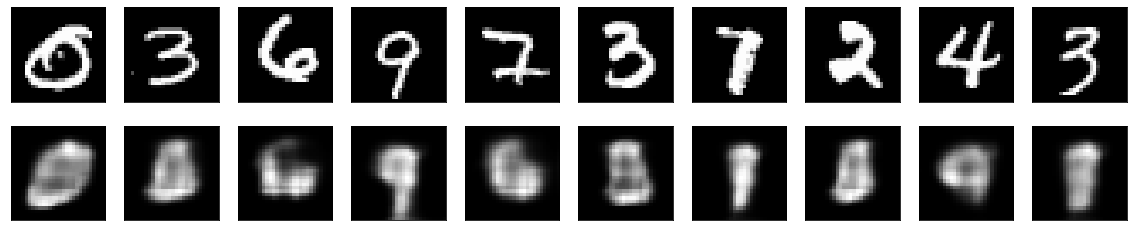

In [91]:
encoded_imgs_train = all_encoder.predict(X_train)
encoded_imgs_validate = all_encoder.predict(X_validate)
encoded_imgs_test = all_encoder.predict(X_test)

decoded_imgs = all_decoder.predict(encoded_imgs_test)
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig(os.path.join("imgs", "all-conv-ae.png"))

In [ ]:
eval_train = all_ae.evaluate(X_train, X_train)
eval_validate = all_ae.evaluate(X_validate, X_validate)
eval_test = all_ae.evaluate(X_test, X_test)
eval_train, eval_validate, eval_test

**"one" auto encoder**

Learning features of the digit one. Afterwards, the distribution of the features will be computed to detect outliers which have low probability.

In [87]:
X_one = digit_data[1][0]
y_one = digit_data[1][1]

(X_one_train, X_one_test, X_one_validate), (y_one_train, y_one_test, y_one_validate) = train_test_split(X_one, y_one)
len(X_one_train), len(X_one_test), len(X_one_validate)

(5513, 1182, 1182)

In [100]:
ckpt_loc = os.path.join(CUR_DIR, "ckpts", "%s-conv-ae.hdf5" % digits_verbose[1])

if(os.path.isfile(ckpt_loc)):
    print("Loading Autoencoder %s from directory %s..." % (digits_verbose[1] ,ckpt_loc))
    one_ae = load_model(ckpt_loc)
    one_encoder, one_decoder = get_codec_from_aue(one_ae)
else:
    print("Training Autoencoder for digit %s..." %digits_verbose[1])
    one_ae, one_encoder, one_decoder = build_conv_aue()
    earlyStopping = EarlyStopping(
        monitor='val_loss', patience=10, verbose=1, mode='min', min_delta=0.0005)
    mcp_save = ModelCheckpoint(ckpt_loc,
                               save_best_only=True, verbose=1, monitor='val_loss', mode='min')
    reduce_lr_loss = ReduceLROnPlateau(
        monitor='val_loss', factor=0.3, patience=3, verbose=1, mode='min')
    one_ae.fit(X_one_train, X_one_train,
                    epochs=128,
                    batch_size=128,
                    shuffle=True,
                    validation_data=(X_one_validate, X_one_validate), callbacks=[earlyStopping, mcp_save, reduce_lr_loss])
one_ae.summary()

Training Autoencoder for digit one...
Train on 5513 samples, validate on 1182 samples
Epoch 1/128
5513/5513 [==============================] - 9s 2ms/step - loss: 0.3220 - val_loss: 0.1527

Epoch 00001: val_loss improved from inf to 0.15273, saving model to .\ckpts\one-conv-ae.hdf5
Epoch 2/128
5513/5513 [==============================] - 6s 1ms/step - loss: 0.1377 - val_loss: 0.1318

Epoch 00002: val_loss improved from 0.15273 to 0.13183, saving model to .\ckpts\one-conv-ae.hdf5
Epoch 3/128
5513/5513 [==============================] - 6s 1ms/step - loss: 0.1232 - val_loss: 0.1173

Epoch 00003: val_loss improved from 0.13183 to 0.11729, saving model to .\ckpts\one-conv-ae.hdf5
Epoch 4/128
5513/5513 [==============================] - 7s 1ms/step - loss: 0.1086 - val_loss: 0.1042

Epoch 00004: val_loss improved from 0.11729 to 0.10422, saving model to .\ckpts\one-conv-ae.hdf5
Epoch 5/128
5513/5513 [==============================] - 6s 1ms/step - loss: 0.0983 - val_loss: 0.0914

Epoch 0000

5513/5513 [==============================] - 6s 1ms/step - loss: 0.0582 - val_loss: 0.0582

Epoch 00043: val_loss improved from 0.05825 to 0.05824, saving model to .\ckpts\one-conv-ae.hdf5
Epoch 00043: early stopping
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 7, 7, 8)           0         
_________________________________________________________

In [101]:
eval_one_train = one_ae.evaluate(X_one_train, X_one_train)
eval_one_validate = one_ae.evaluate(X_one_validate, X_one_validate)
eval_one_test = one_ae.evaluate(X_one_test, X_one_test)
eval_one_train, eval_one_validate, eval_one_test

1182/1182 [==============================] - 0s 299us/step


(0.05821592615079084, 0.058238907999244034, 0.06028889790303413)

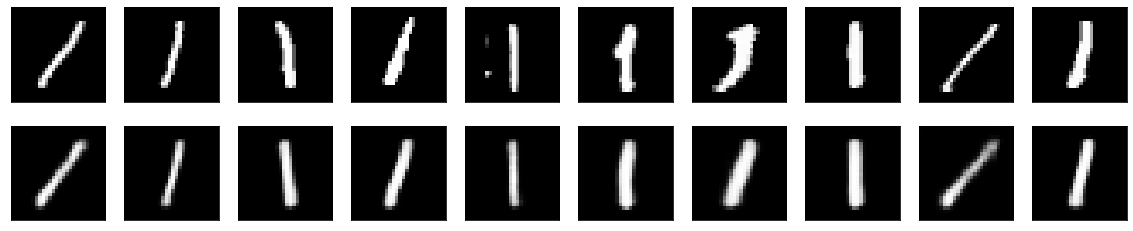

In [191]:
encoded_one_imgs_train = one_encoder.predict(X_one_train)
encoded_one_imgs_validate = one_encoder.predict(X_one_validate)
encoded_one_imgs_test = one_encoder.predict(X_one_test)

decoded_one_imgs = one_decoder.predict(encoded_one_imgs_train)
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_one_train[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_one_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig(os.path.join("imgs", "one-conv-ae.png"))

## All digits classifier

In [148]:
flat = np.prod(encoded_imgs_train.shape[1:], dtype=np.int64)
encoded_imgs_train = encoded_imgs_train.reshape(len(encoded_imgs_train), flat)
encoded_imgs_validate = encoded_imgs_validate.reshape(
    len(encoded_imgs_validate), flat)
encoded_imgs_test = encoded_imgs_test.reshape(len(encoded_imgs_test), flat)

In [12]:
ckpt_loc = os.path.join(CUR_DIR, "ckpts", "classifier.hdf5")
if(os.path.isfile(ckpt_loc)):
    print("Loading classifier from directory %s..." % ckpt_loc)
    classifier = load_model(ckpt_loc)
else:
    print("Training classifier...")
    classifier = build_classifier(input_dim=flat)
    earlyStopping = EarlyStopping(
        monitor='val_acc', patience=5, verbose=1, mode='max',  min_delta=0.0005)
    mcp_save = ModelCheckpoint(ckpt_loc,
                               save_best_only=True, verbose=1, monitor='val_acc', mode='max')
    reduce_lr_loss = ReduceLROnPlateau(
        monitor='val_acc', factor=0.3, patience=3, verbose=1, mode='max')
    classifier.fit(encoded_imgs_train, y_train, validation_data=(
        encoded_imgs_validate, y_validate), batch_size=16, epochs=32, shuffle=True, callbacks=[earlyStopping, mcp_save, reduce_lr_loss])

Loading classifier from directory .\ckpts\classifier.hdf5...


In [13]:
eval_train = classifier.evaluate(encoded_imgs_train, y_train)
eval_validate = classifier.evaluate(encoded_imgs_validate, y_validate)
eval_test = classifier.evaluate(encoded_imgs_test, y_test)
eval_train,eval_validate, eval_test

10500/10500 [==============================] - 0s 16us/step


([0.02167299955170982, 0.8574489795918367],
 [0.02172161699725049, 0.8558095238095238],
 [0.021641029388954243, 0.858])

In [14]:
def get_cm(input, y_true):
    """Computes confusion matrix."""
    y_pred = tf.argmax(classifier.predict(input), axis=1)
    y_true = tf.argmax(y_true, axis=1)

    c = tf.keras.backend.eval(y_pred)
    d = tf.keras.backend.eval(y_true)

    return confusion_matrix(c, d)

In [15]:
def precision(cm):
    results = []
    for i in range(len(cm)):  # rows
        TP = cm[i][i]
        fp_tp = np.sum(cm[i])
        results.append(TP/fp_tp)
    return results + [np.mean(results)]

In [16]:
def recall(cm):
    results = []
    for i in range(len(cm)):  # rows
        TP = cm[i][i]
        tp_fn = 0
        for j in range(len(cm[i])):
            tp_fn += cm[j][i]
        results.append(TP/tp_fn)
    return results + [np.mean(results)]

In [17]:
cm_train = get_cm(encoded_imgs_train, y_train)
print(cm_train, precision(cm_train)[-1], recall(cm_train)[-1], sep="\n")

cm_validate = get_cm(encoded_imgs_validate, y_validate)
print(cm_validate, precision(cm_validate)[-1], recall(cm_validate)[-1], sep="\n")

cm_test = get_cm(encoded_imgs_test, y_test)
print(cm_test, precision(cm_test)[-1], recall(cm_test)[-1], sep="\n")

[[4639    2   38   28    3  178  184   10  123   49]
 [   3 5296   15   17   26   42   72   43   94   50]
 [   6   39 4200  199   73   33   41   45  132   29]
 [  10   49  146 4007    0  277    5   25  134   43]
 [   8   14   77    6 3842   78   87   62   41  103]
 [  54   26   21  298   12 3464  102   23  183   93]
 [  83    9   78   28   92  111 4343    2   24   10]
 [   1    1   53  115  157   48    2 4332   50  416]
 [  55   30  257  198   38  111   30   89 3806   32]
 [   3   11    4   45  475  102    2  513  159 4086]]
0.8569204237780838
0.8553180962638333
[[ 970    0   13    6    2   45   45    2   29   16]
 [   0 1164    2    5    6    7   23    8   17   10]
 [   1   14  935   41   17    7    5    8   26    2]
 [   2    9   30  853    1   84    2    8   30   10]
 [   0    2   16    3  816   21   17    7    4   22]
 [  15    7    2   62    6  727   22    7   32   23]
 [  17    1   14    6   21   25  902    1    7    1]
 [   0    2   12   13   31    7    0  940   11   81]
 [  13 

# Anomaly Detection with DJ CF Gauss

In [199]:
one_flat = np.prod(encoded_one_imgs_train.shape[1:], dtype=np.int64)
encoded_one_imgs_train = encoded_one_imgs_train.reshape(len(encoded_one_imgs_train), one_flat)
encoded_one_imgs_validate = encoded_one_imgs_validate.reshape(
    len(encoded_one_imgs_validate), one_flat)
encoded_one_imgs_test = encoded_one_imgs_test.reshape(len(encoded_one_imgs_test), one_flat)

In [200]:
def gauss(x_i, my_i, sigma_i2):
    # gaussian distribution for one feature
    if sigma_i2 == 0:
        return 1 if x_i == my_i  else 0
    return np.array((1/np.sqrt(2*np.pi*sigma_i2)) *
                    np.exp(-(x_i-my_i)**2/(2*sigma_i2)))

In [201]:
def my(X):
    return np.array([(1 / len(x)) * np.sum(x) for x in X.T])

In [202]:
def sigma2(X, my):
    # computes sigma squared for each feature
    m = len(X)  # number of data points
    return np.array([(1/m)*np.sum((X[:, i] - my[i]) ** 2) for i in range(len(my))])

In [203]:
def p(X,my,sigma2):
    return np.array([np.prod([gauss(x[i], my[i], sigma2[i])
               for i in range(len(x))]) for x in X])

In [212]:
X = encoded_one_imgs_train
m = len(X)
number_of_features = len(X[0])
my =  np.array([(1 / len(x)) * np.sum(x) for x in X.T])
sigma_2 =  np.array([np.sum((X[:, i] - my[i]) ** 2)/m for i in range(number_of_features)])

p_all = np.sort(p(X,my,sigma_2))
epsilon = 1e-7
thresholded_P = p_all[np.where(p_all>epsilon)]
len(thresholded_P)/len(p_all), my, sigma_2

(0.3085434427716307,
 array([5.74742122, 0.44621444, 2.36269014, 1.38133393, 2.4863508 ,
        1.97173655, 2.94518815, 2.98682482, 5.03457453, 0.00760209,
        0.02231443, 0.26576888, 5.98679187, 0.99413186, 2.0772092 ,
        2.21378482, 3.13146838, 3.5878343 , 2.44731593, 4.11176955,
        3.73134452, 0.37064439, 0.82515165, 0.82364358]),
 array([0.53448401, 0.18175197, 0.3729777 , 0.29451056, 1.00045073,
        1.39281868, 1.10982883, 2.2672614 , 0.59417668, 0.00410216,
        0.01161364, 0.20019766, 0.5944198 , 1.38495091, 0.19036822,
        0.19096008, 0.27968917, 0.20650282, 0.62749069, 1.45688352,
        1.81007427, 0.08772213, 0.23008042, 0.35293536]))

## Distribution of the Encoded Features

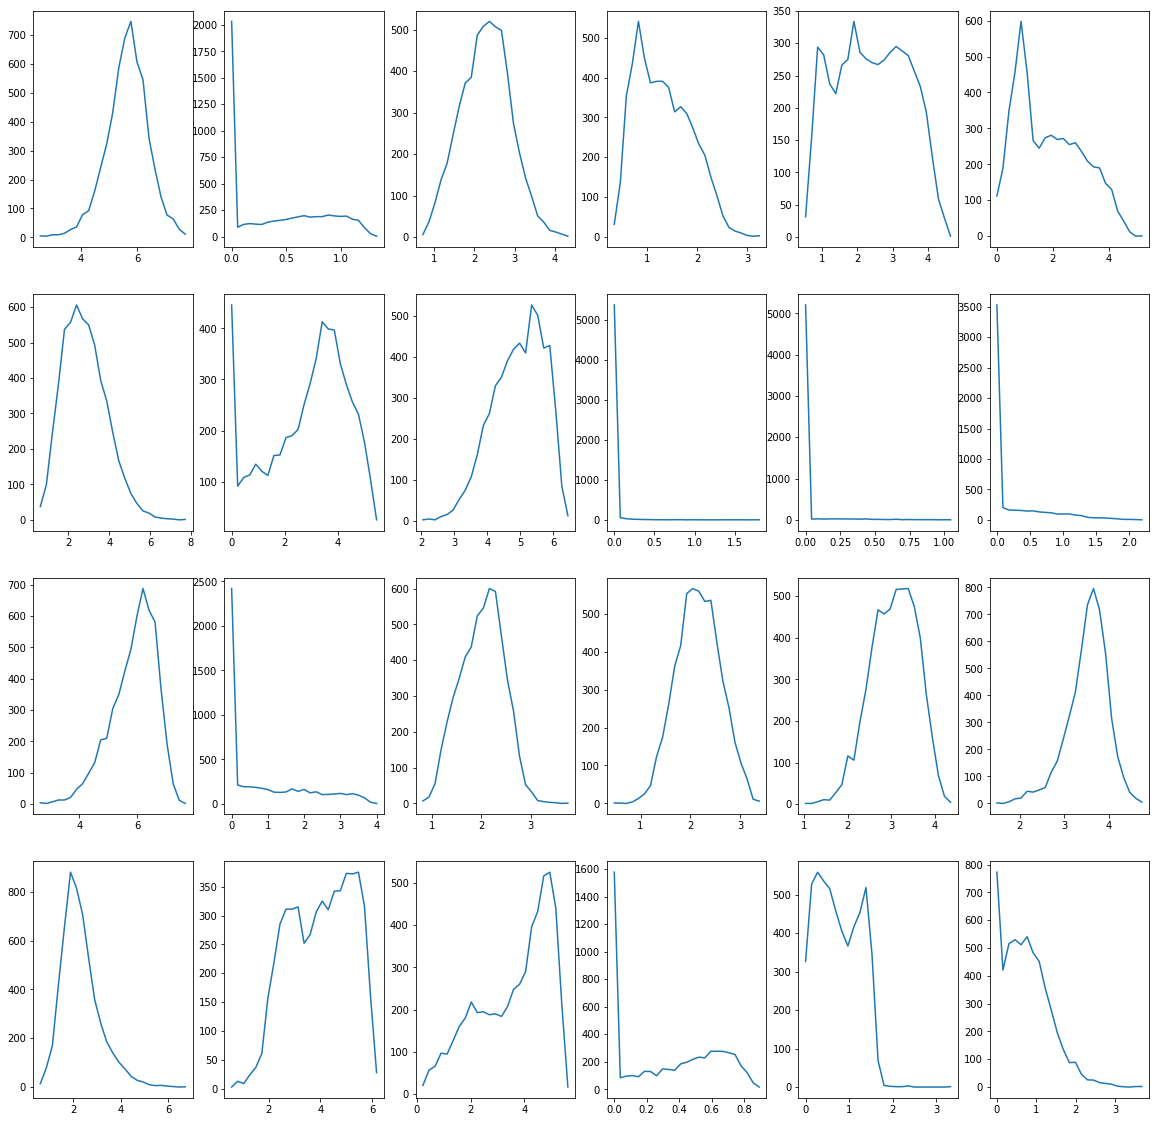

In [213]:
plt.figure(figsize=(20, 20))
for i in range(len(my)):
    # plots distribution of i-th feature
    # display original
    bins = 25
    hist = np.histogram(X[:, i], bins=bins)
    ax = plt.subplot(4, 6, i + 1)
    h_min = min(hist[1])
    h_max = max(hist[1])
    delta = abs(h_max - h_min)
    r = np.arange(h_min, h_max, delta / bins)
    
    plt.plot(r, hist[0])

In [185]:
def convert_values_to_img(values):
    values = np.reshape(values,(1,2,2,6))
    random_img = decoder.predict(values)
    return np.reshape(random_img, (28,28))

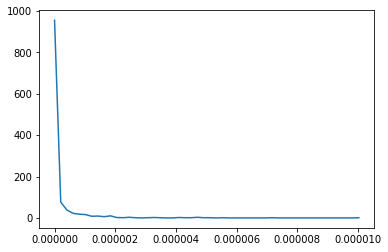

In [186]:
bins = 50
hist_all = np.histogram(p_all,bins =bins)
h_min = min(hist_all[1])
h_max = max(hist_all[1])
delta = abs(h_max-h_min)
r = np.arange(h_min,h_max, delta/bins)
plt.plot(r,hist_all[0])